 # DQN Training in Maze Environment (Hyperparameterized)

In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from collections import deque


2025-04-13 16:48:01.205675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744559281.222124 1057657 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744559281.226657 1057657 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 16:48:01.244134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 ## Hyperparameters

In [2]:
hyperparams = {
    "learning_rate": [1e-4, 5e-5, 1e-5],
    "gamma": [0.90, 0.96, 0.99],
    "epsilon_decay_episodes": [0.9, 0.99],
    "batch_size": [32, 64, 128],
    "replay_buffer_size": [4000, 8000, 16000],
    "episodes": [1000, 2000, 3000],  # You can keep 3000 fixed if preferred
    "hidden_layers": [
        [64, 64], 
        [128, 64], 
        [64, 64, 64], 
        [128, 128], 
        [256, 128]
    ],
    "activation": ["relu", "elu", "tanh"]
}

def generate_param_combinations(grid):
    keys = list(grid.keys())
    values = list(grid.values())
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))

shared_params = {
    "epsilon_start": 1.0,
    "epsilon_min": 0.01,
    "replay_buffer_size": 8000,
    "steps_per_episode": 3000,
    "target_update_freq": 500,
    "random_seed": 42,
    "maze_width": 10,
    "maze_height": 10,
    "maze_imperfections": 5,
    "input_dim": 19,
    "n_outputs": 4,
    "log_every": 100,
    "q_log_every": 500,
    "plot_every": 100,
    "train_after": 20
}


# Constants

In [3]:
random_seed = 42
maze_width = 10
maze_height = 10
input_shape = [19]
n_outputs = 4


 ## Maze Setup

In [4]:
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

env = maze_library.init_environment_python(maze_width, maze_height, 5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)


In [5]:
def map_int_to_direction(input):
    return [
        maze_library.Direction.North,
        maze_library.Direction.East,
        maze_library.Direction.South,
        maze_library.Direction.West
    ][input]

def action_result_to_tuple(action_result):
    return (
        action_result.observation,
        action_result.reward,
        action_result.is_done,
        action_result.is_truncated,
        action_result.info
    )

def action_result_to_input_vector(state, info):
    ap = state.available_paths
    vp = state.visited_paths
    return np.array([
        ap.get(maze_library.Direction.North, 0),
        vp.get(maze_library.Direction.North, False),
        ap.get(maze_library.Direction.East, 0),
        vp.get(maze_library.Direction.East, False),
        ap.get(maze_library.Direction.South, 0),
        vp.get(maze_library.Direction.South, False),
        ap.get(maze_library.Direction.West, 0),
        vp.get(maze_library.Direction.West, False),
        info.previous_direction,
        state.current_location[0],
        state.current_location[1],
        state.end_node[0],
        state.end_node[1],
        info.previous_node[0],
        info.previous_node[1],
        info.manhattan_distance,
        info.goal_dx,
        info.goal_dy,
        info.visited_amount
    ])


 ## Model Definition

In [6]:

def create_model(hyperprm):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    for units in hyperprm["hidden_layers"]:
        model.add(tf.keras.layers.Dense(units, activation=hyperprm["activation"]))
    model.add(tf.keras.layers.Dense(n_outputs))

    optimizer = tf.keras.optimizers.Nadam(learning_rate=hyperprm["learning_rate"])
    loss_fn = tf.keras.losses.Huber(delta=1.0)
    return model, optimizer, loss_fn


 ## Policy and Replay Buffer

In [7]:

def epsilon_greedy_policy(state, epsilon, model):
    if np.random.rand() < epsilon:
        return np.random.choice(n_outputs)
    Q_values = model.predict(state[np.newaxis], verbose=0)[0]
    return np.argmax(Q_values)

def sample_experiences(batch_size, replay_buffer):
    sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
    half_batch = batch_size // 2
    if len(sorted_experiences) < batch_size:
        batch = sorted_experiences
    else:
        high_priority = sorted_experiences[:half_batch]
        random_other = [sorted_experiences[i] for i in np.random.choice(len(sorted_experiences), half_batch, replace=False)]
        batch = high_priority + random_other
    return [
        np.array([experience[i] for experience in batch], dtype=np.float32)
        for i in range(6)
    ]


In [8]:


def play_one_step(env, state, info, epsilon,model, replay_buffer, reward_log):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon, model)
    action_obj = maze_library.create_action(map_int_to_direction(action), 0)
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, new_info


In [9]:
def training_step(model, optimizer, loss_fn, hyperprm, replay_buffer, q_value_log):
    states, actions, rewards, next_states, dones, truncateds = sample_experiences(hyperprm["batch_size"], replay_buffer)
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q = np.max(next_Q_values, axis=1)
    not_done = 1.0 - dones
    targets = rewards + not_done * hyperprm["gamma"] * max_next_Q
    targets = targets.reshape(-1, 1)

    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q = model(states)
        Q_values = tf.reduce_sum(all_Q * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(targets, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [10]:
def plot_q_values(q_value_log):
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


 ## Training Loop

In [11]:
def run_single_experiment(hyperprm, run_id):
    all_episode_rewards  = []
    reward_log = []
    q_value_log = []
    best_weights = None
    highest_reward = -float("inf")
    model, optimizer, loss_fn = create_model(hyperprm)
    replay_buffer = deque(maxlen=hyperprm["replay_buffer_size"])

    for episode in range(hyperprm["episodes"]):
        result = env.reset()
        obs, reward, done, truncated, info = action_result_to_tuple(result)
        cumulative_reward = 0

        for step in range(hyperprm["steps_per_episode"]):
            eps_decay = episode / (hyperprm["episodes"] * hyperprm["epsilon_decay_episodes"])
            epsilon = max(hyperprm["epsilon_start"] - eps_decay, hyperprm["epsilon_min"])
            obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon,model, replay_buffer, reward_log)
            cumulative_reward += reward
            if done or truncated:
                break

        if episode > hyperprm["train_after"]:
            training_step(model, optimizer, loss_fn, hyperprm, replay_buffer, q_value_log)
        
        if cumulative_reward > highest_reward:
            highest_reward = cumulative_reward
            best_weights = model.get_weights()

        if episode % hyperprm["log_every"] == 0:
            print(f"Episode {episode} - Reward: {cumulative_reward:.2f}, Epsilon: {epsilon:.3f}")

        # if episode % hyperprm["q_log_every"] == 0 and episode > 0:

        all_episode_rewards.append(cumulative_reward)
        
    plot_q_values(q_value_log)

    model.set_weights(best_weights)
    return {
        "params": hyperparams,
        "rewards": all_episode_rewards,
        "q_values": q_value_log,
        "final_model": model,
    }


I0000 00:00:1744559283.063380 1057657 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4701 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:06:00.0, compute capability: 6.1


Episode 0 - Reward: -18.50, Epsilon: 1.000


I0000 00:00:1744559283.933789 1057770 service.cc:148] XLA service 0x7f3168006340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744559283.933965 1057770 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-04-13 16:48:03.938574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744559283.952376 1057770 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744559284.053598 1057770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode 100 - Reward: -40.20, Epsilon: 0.889
Episode 200 - Reward: -20.10, Epsilon: 0.778
Episode 300 - Reward: -18.25, Epsilon: 0.667
Episode 400 - Reward: -17.80, Epsilon: 0.556
Episode 500 - Reward: -17.90, Epsilon: 0.444
Episode 600 - Reward: -24.10, Epsilon: 0.333
Episode 700 - Reward: -17.85, Epsilon: 0.222
Episode 800 - Reward: -18.00, Epsilon: 0.111
Episode 900 - Reward: -15.45, Epsilon: 0.010


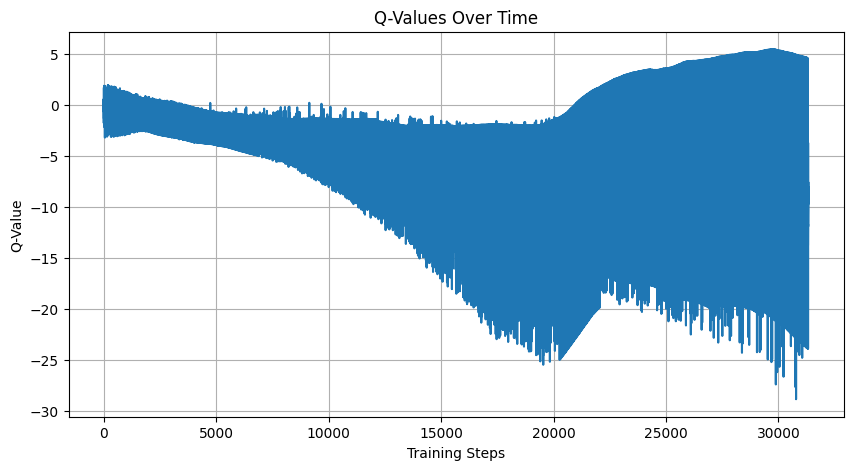

Episode 0 - Reward: -18.50, Epsilon: 1.000
Episode 100 - Reward: -22.00, Epsilon: 0.889
Episode 200 - Reward: -12.30, Epsilon: 0.778
Episode 300 - Reward: -20.20, Epsilon: 0.667
Episode 400 - Reward: -19.15, Epsilon: 0.556
Episode 500 - Reward: -17.75, Epsilon: 0.444
Episode 600 - Reward: -18.25, Epsilon: 0.333
Episode 700 - Reward: -20.80, Epsilon: 0.222
Episode 800 - Reward: -20.20, Epsilon: 0.111
Episode 900 - Reward: -17.00, Epsilon: 0.010


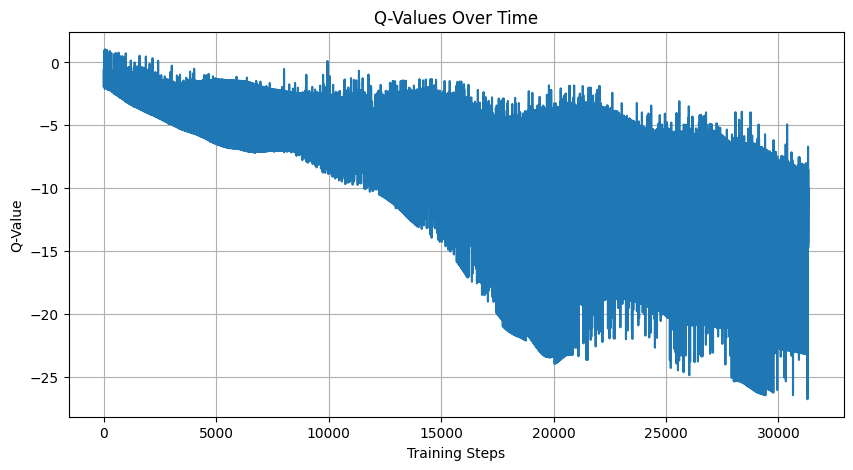

Episode 0 - Reward: -20.25, Epsilon: 1.000
Episode 100 - Reward: -12.25, Epsilon: 0.889
Episode 200 - Reward: -24.35, Epsilon: 0.778
Episode 300 - Reward: -23.95, Epsilon: 0.667
Episode 400 - Reward: -27.45, Epsilon: 0.556
Episode 500 - Reward: -19.45, Epsilon: 0.444
Episode 600 - Reward: -21.20, Epsilon: 0.333
Episode 700 - Reward: -32.40, Epsilon: 0.222
Episode 800 - Reward: -19.70, Epsilon: 0.111
Episode 900 - Reward: -19.20, Epsilon: 0.010


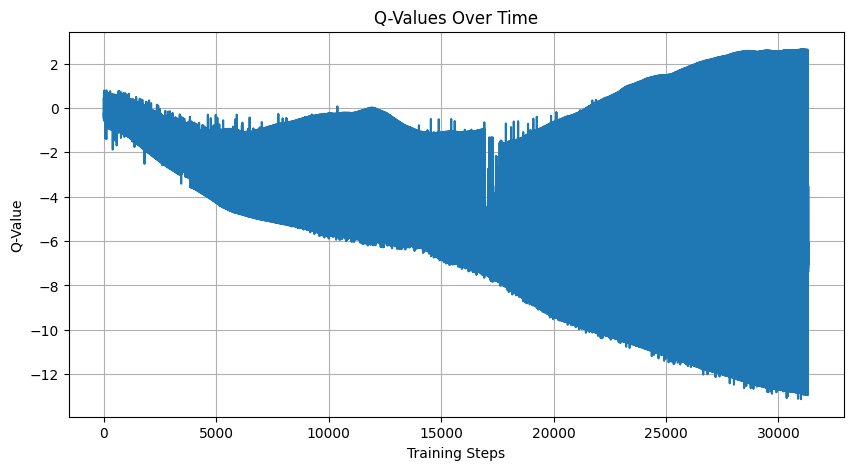

Episode 0 - Reward: -26.65, Epsilon: 1.000
Episode 100 - Reward: -16.00, Epsilon: 0.889
Episode 200 - Reward: -20.05, Epsilon: 0.778
Episode 300 - Reward: -15.95, Epsilon: 0.667
Episode 400 - Reward: -19.70, Epsilon: 0.556
Episode 500 - Reward: -19.25, Epsilon: 0.444
Episode 600 - Reward: -17.40, Epsilon: 0.333
Episode 700 - Reward: -19.60, Epsilon: 0.222
Episode 800 - Reward: -16.20, Epsilon: 0.111
Episode 900 - Reward: -17.15, Epsilon: 0.010


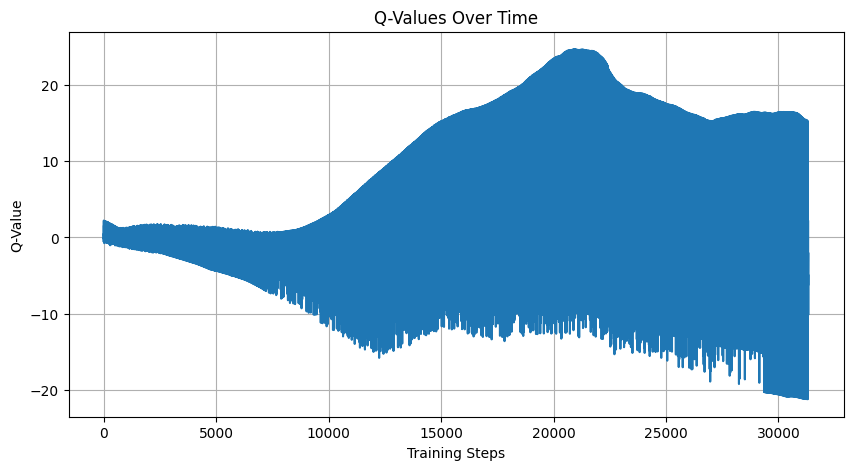

Episode 0 - Reward: -24.25, Epsilon: 1.000
Episode 100 - Reward: -16.05, Epsilon: 0.889
Episode 200 - Reward: -16.80, Epsilon: 0.778
Episode 300 - Reward: -15.55, Epsilon: 0.667
Episode 400 - Reward: -22.20, Epsilon: 0.556
Episode 500 - Reward: -20.50, Epsilon: 0.444
Episode 600 - Reward: -21.00, Epsilon: 0.333
Episode 700 - Reward: -18.75, Epsilon: 0.222
Episode 800 - Reward: -17.15, Epsilon: 0.111
Episode 900 - Reward: -17.50, Epsilon: 0.010


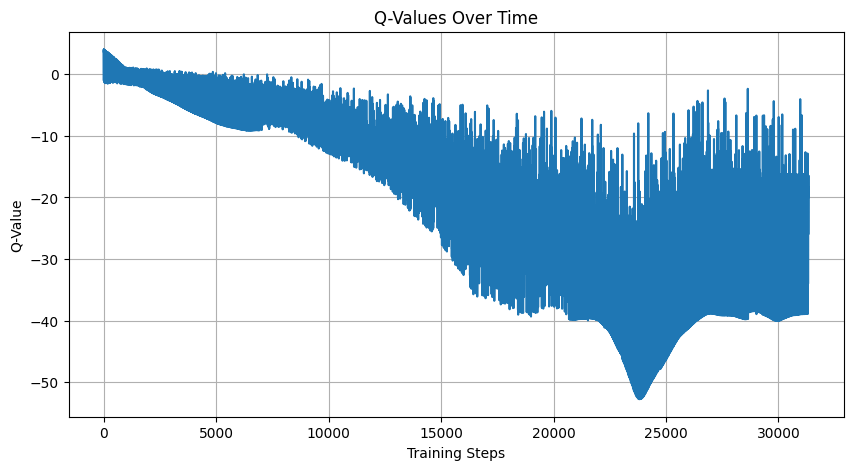

Episode 0 - Reward: -20.85, Epsilon: 1.000
Episode 100 - Reward: -30.90, Epsilon: 0.889
Episode 200 - Reward: -16.70, Epsilon: 0.778
Episode 300 - Reward: -27.35, Epsilon: 0.667
Episode 400 - Reward: -15.20, Epsilon: 0.556
Episode 500 - Reward: -10.40, Epsilon: 0.444
Episode 600 - Reward: -20.15, Epsilon: 0.333
Episode 700 - Reward: -17.15, Epsilon: 0.222
Episode 800 - Reward: -17.35, Epsilon: 0.111
Episode 900 - Reward: -17.60, Epsilon: 0.010


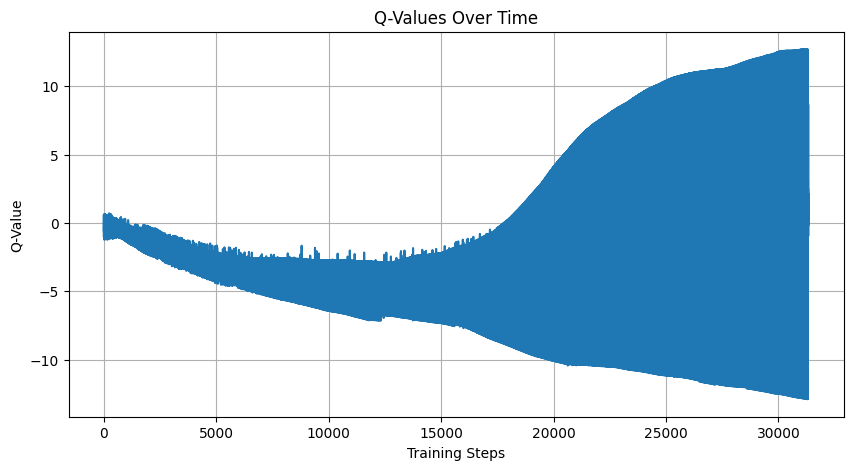

Episode 0 - Reward: -16.50, Epsilon: 1.000
Episode 100 - Reward: -21.75, Epsilon: 0.889
Episode 200 - Reward: -14.35, Epsilon: 0.778
Episode 300 - Reward: -19.55, Epsilon: 0.667
Episode 400 - Reward: -18.40, Epsilon: 0.556
Episode 500 - Reward: -19.45, Epsilon: 0.444
Episode 600 - Reward: -18.60, Epsilon: 0.333
Episode 700 - Reward: -17.80, Epsilon: 0.222
Episode 800 - Reward: -20.15, Epsilon: 0.111
Episode 900 - Reward: -17.50, Epsilon: 0.010


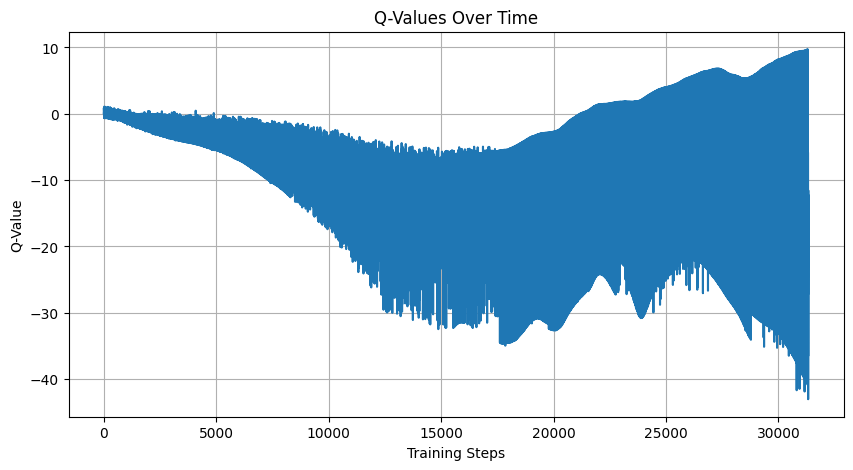

Episode 0 - Reward: -18.25, Epsilon: 1.000
Episode 100 - Reward: -24.80, Epsilon: 0.889
Episode 200 - Reward: -25.75, Epsilon: 0.778
Episode 300 - Reward: -20.35, Epsilon: 0.667
Episode 400 - Reward: -14.25, Epsilon: 0.556
Episode 500 - Reward: -19.45, Epsilon: 0.444
Episode 600 - Reward: -22.55, Epsilon: 0.333
Episode 700 - Reward: -19.65, Epsilon: 0.222
Episode 800 - Reward: -21.80, Epsilon: 0.111
Episode 900 - Reward: -14.65, Epsilon: 0.010


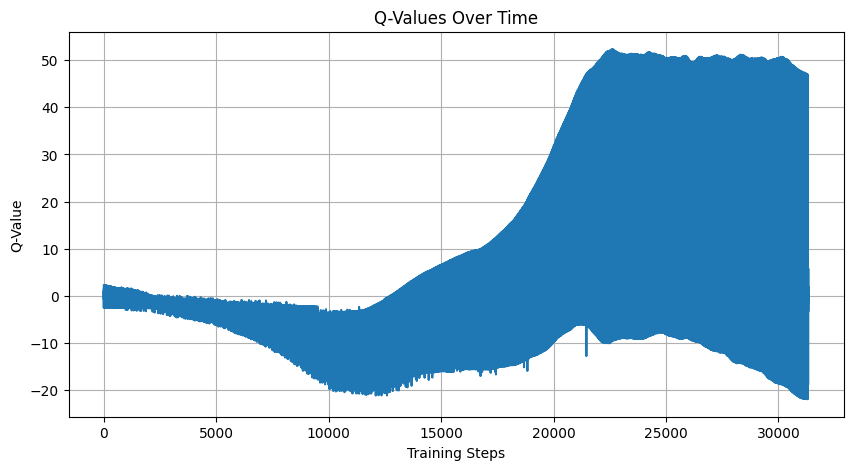

Episode 0 - Reward: -19.95, Epsilon: 1.000
Episode 100 - Reward: -16.70, Epsilon: 0.889
Episode 200 - Reward: -41.85, Epsilon: 0.778
Episode 300 - Reward: -19.70, Epsilon: 0.667
Episode 400 - Reward: -19.20, Epsilon: 0.556
Episode 500 - Reward: -21.65, Epsilon: 0.444
Episode 600 - Reward: -14.85, Epsilon: 0.333
Episode 700 - Reward: -14.40, Epsilon: 0.222
Episode 800 - Reward: -18.00, Epsilon: 0.111
Episode 900 - Reward: -18.00, Epsilon: 0.010


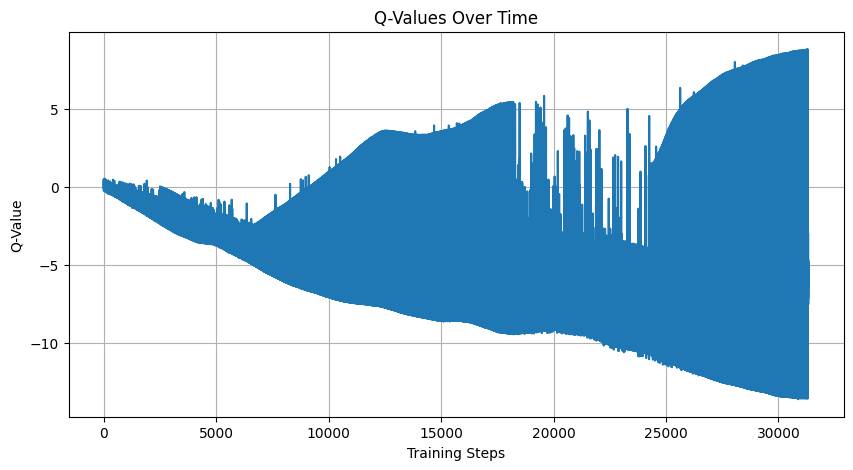

Episode 0 - Reward: -19.50, Epsilon: 1.000
Episode 100 - Reward: -15.70, Epsilon: 0.889
Episode 200 - Reward: -23.05, Epsilon: 0.778
Episode 300 - Reward: -20.30, Epsilon: 0.667
Episode 400 - Reward: -20.05, Epsilon: 0.556
Episode 500 - Reward: -18.10, Epsilon: 0.444
Episode 600 - Reward: -19.25, Epsilon: 0.333
Episode 700 - Reward: -17.75, Epsilon: 0.222
Episode 800 - Reward: -18.00, Epsilon: 0.111
Episode 900 - Reward: -17.50, Epsilon: 0.010


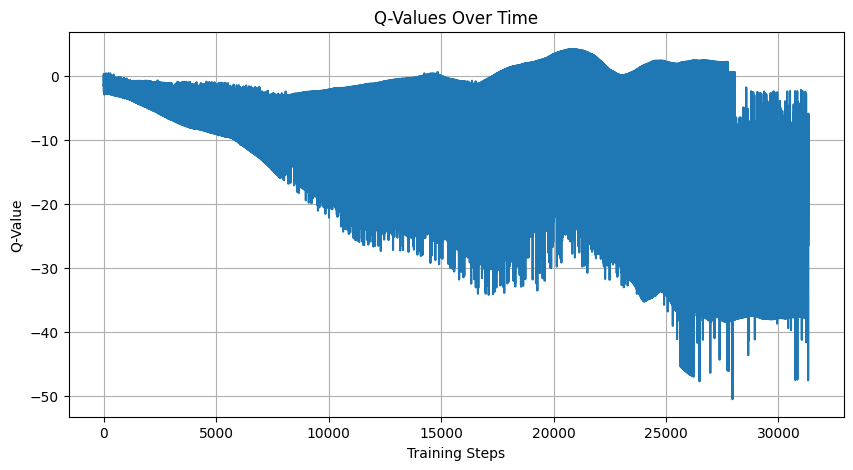

Episode 0 - Reward: -17.45, Epsilon: 1.000
Episode 100 - Reward: -16.75, Epsilon: 0.889
Episode 200 - Reward: -13.80, Epsilon: 0.778
Episode 300 - Reward: -15.80, Epsilon: 0.667
Episode 400 - Reward: -18.95, Epsilon: 0.556
Episode 500 - Reward: -18.70, Epsilon: 0.444
Episode 600 - Reward: -23.80, Epsilon: 0.333
Episode 700 - Reward: -18.25, Epsilon: 0.222
Episode 800 - Reward: -26.15, Epsilon: 0.111
Episode 900 - Reward: -15.60, Epsilon: 0.010


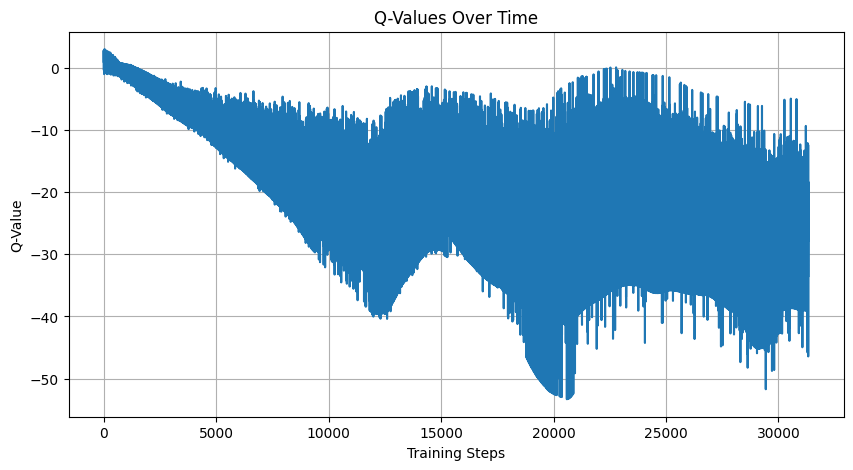

Episode 0 - Reward: -20.00, Epsilon: 1.000
Episode 100 - Reward: -14.15, Epsilon: 0.889
Episode 200 - Reward: -16.50, Epsilon: 0.778
Episode 300 - Reward: -25.00, Epsilon: 0.667
Episode 400 - Reward: -19.95, Epsilon: 0.556
Episode 500 - Reward: -14.70, Epsilon: 0.444
Episode 600 - Reward: -17.30, Epsilon: 0.333
Episode 700 - Reward: -21.15, Epsilon: 0.222
Episode 800 - Reward: -17.15, Epsilon: 0.111
Episode 900 - Reward: -16.00, Epsilon: 0.010


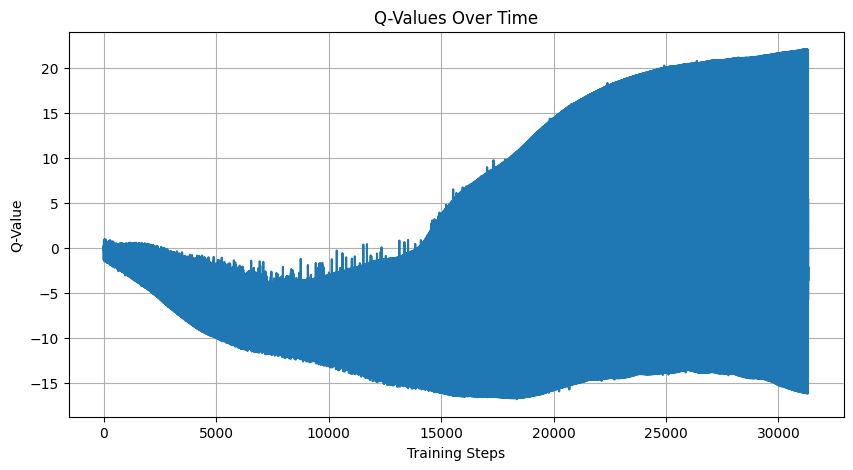

Episode 0 - Reward: -10.70, Epsilon: 1.000
Episode 100 - Reward: -21.65, Epsilon: 0.889
Episode 200 - Reward: -18.25, Epsilon: 0.778
Episode 300 - Reward: -13.65, Epsilon: 0.667
Episode 400 - Reward: -17.10, Epsilon: 0.556
Episode 500 - Reward: -32.10, Epsilon: 0.444
Episode 600 - Reward: -20.75, Epsilon: 0.333
Episode 700 - Reward: -20.85, Epsilon: 0.222
Episode 800 - Reward: -17.15, Epsilon: 0.111
Episode 900 - Reward: -18.20, Epsilon: 0.010


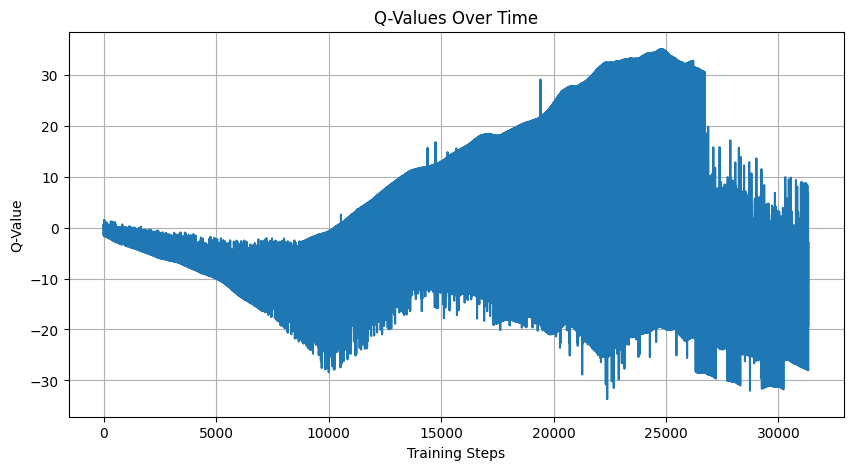

Episode 0 - Reward: -17.55, Epsilon: 1.000
Episode 100 - Reward: -14.15, Epsilon: 0.889
Episode 200 - Reward: -12.05, Epsilon: 0.778
Episode 300 - Reward: -15.10, Epsilon: 0.667
Episode 400 - Reward: -21.45, Epsilon: 0.556
Episode 500 - Reward: -19.85, Epsilon: 0.444
Episode 600 - Reward: -18.10, Epsilon: 0.333
Episode 700 - Reward: -19.15, Epsilon: 0.222
Episode 800 - Reward: -23.25, Epsilon: 0.111
Episode 900 - Reward: -16.30, Epsilon: 0.010


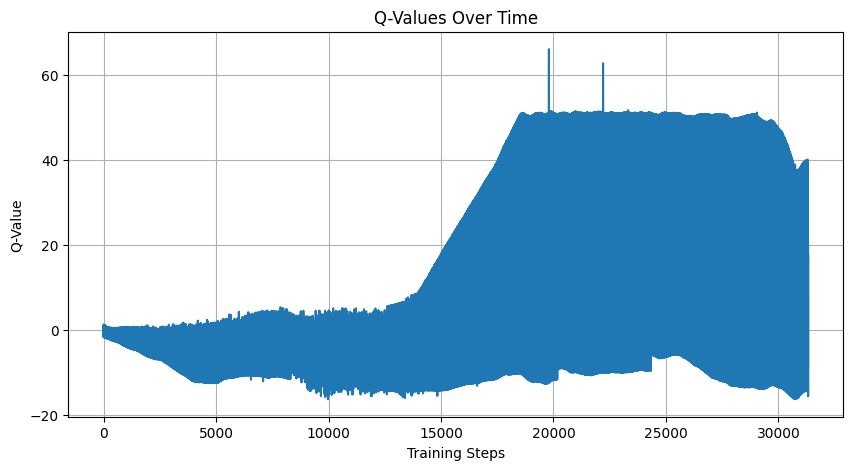

Episode 0 - Reward: -15.60, Epsilon: 1.000
Episode 100 - Reward: -30.70, Epsilon: 0.889
Episode 200 - Reward: -19.10, Epsilon: 0.778
Episode 300 - Reward: -22.45, Epsilon: 0.667
Episode 400 - Reward: -21.75, Epsilon: 0.556
Episode 500 - Reward: -26.65, Epsilon: 0.444
Episode 600 - Reward: -14.00, Epsilon: 0.333
Episode 700 - Reward: -18.45, Epsilon: 0.222
Episode 800 - Reward: -18.60, Epsilon: 0.111
Episode 900 - Reward: -17.60, Epsilon: 0.010


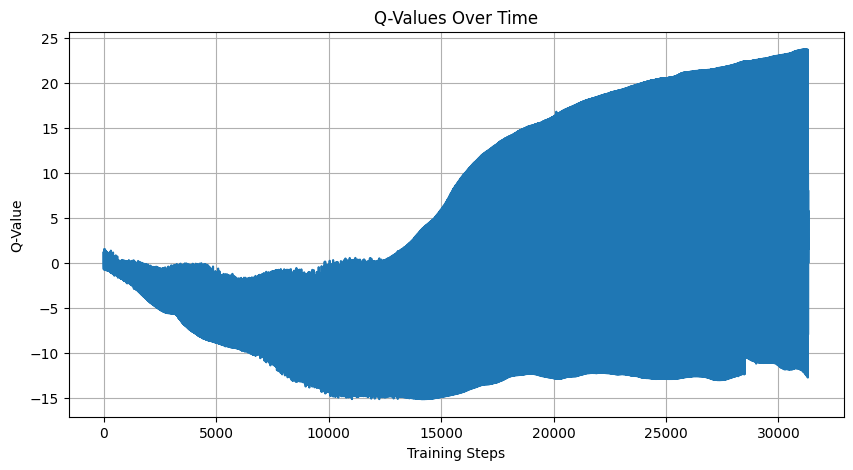

Episode 0 - Reward: -12.80, Epsilon: 1.000
Episode 100 - Reward: -28.80, Epsilon: 0.944
Episode 200 - Reward: -23.25, Epsilon: 0.889
Episode 300 - Reward: 36.45, Epsilon: 0.833
Episode 400 - Reward: -30.40, Epsilon: 0.778
Episode 500 - Reward: -20.70, Epsilon: 0.722
Episode 600 - Reward: -21.85, Epsilon: 0.667
Episode 700 - Reward: -24.85, Epsilon: 0.611
Episode 800 - Reward: -12.85, Epsilon: 0.556
Episode 900 - Reward: -17.75, Epsilon: 0.500
Episode 1000 - Reward: -19.20, Epsilon: 0.444
Episode 1100 - Reward: -19.70, Epsilon: 0.389
Episode 1200 - Reward: -15.75, Epsilon: 0.333
Episode 1300 - Reward: -17.75, Epsilon: 0.278
Episode 1400 - Reward: -19.85, Epsilon: 0.222
Episode 1500 - Reward: -18.20, Epsilon: 0.167
Episode 1600 - Reward: -16.30, Epsilon: 0.111
Episode 1700 - Reward: -21.00, Epsilon: 0.056
Episode 1800 - Reward: -18.20, Epsilon: 0.010
Episode 1900 - Reward: -14.60, Epsilon: 0.010


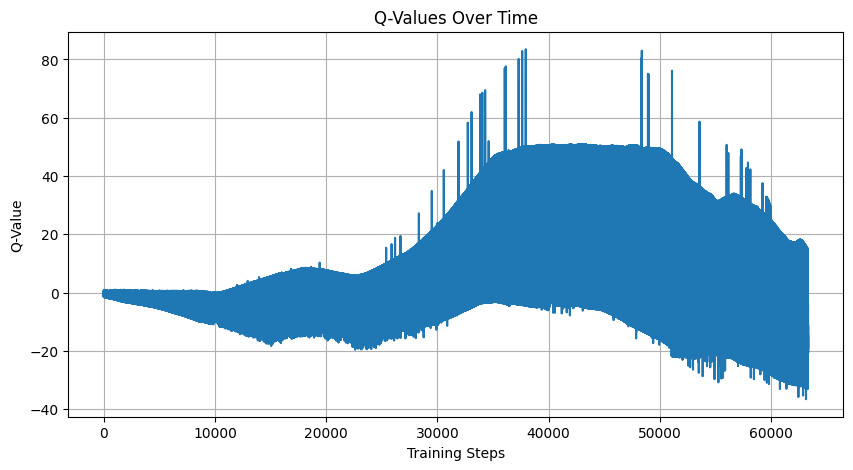

Episode 0 - Reward: -23.00, Epsilon: 1.000
Episode 100 - Reward: -22.35, Epsilon: 0.944
Episode 200 - Reward: -21.65, Epsilon: 0.889
Episode 300 - Reward: -16.05, Epsilon: 0.833
Episode 400 - Reward: -20.55, Epsilon: 0.778
Episode 500 - Reward: -17.35, Epsilon: 0.722
Episode 600 - Reward: -12.55, Epsilon: 0.667
Episode 700 - Reward: -22.35, Epsilon: 0.611
Episode 800 - Reward: -17.45, Epsilon: 0.556
Episode 900 - Reward: -19.65, Epsilon: 0.500
Episode 1000 - Reward: -17.90, Epsilon: 0.444
Episode 1100 - Reward: -17.15, Epsilon: 0.389
Episode 1200 - Reward: -14.70, Epsilon: 0.333
Episode 1300 - Reward: -17.55, Epsilon: 0.278
Episode 1400 - Reward: -14.65, Epsilon: 0.222
Episode 1500 - Reward: -14.40, Epsilon: 0.167
Episode 1600 - Reward: -17.50, Epsilon: 0.111
Episode 1700 - Reward: -17.75, Epsilon: 0.056
Episode 1800 - Reward: -17.60, Epsilon: 0.010
Episode 1900 - Reward: -18.05, Epsilon: 0.010


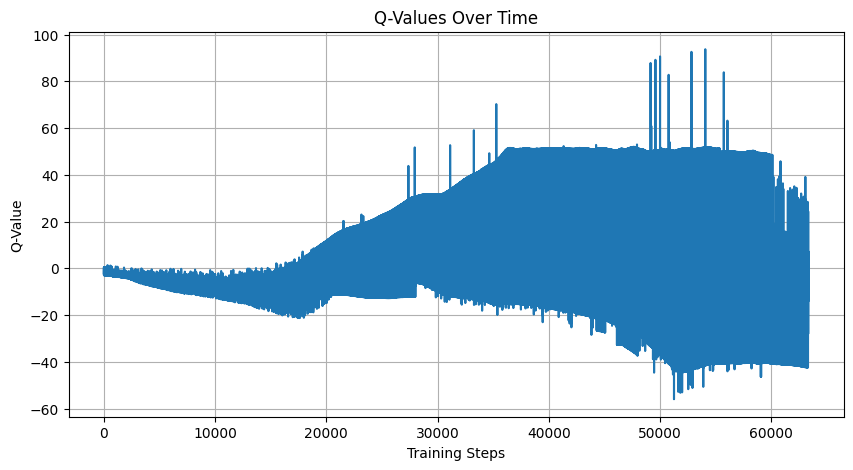

Episode 0 - Reward: -16.15, Epsilon: 1.000
Episode 100 - Reward: -18.05, Epsilon: 0.944
Episode 200 - Reward: -23.25, Epsilon: 0.889
Episode 300 - Reward: -16.60, Epsilon: 0.833
Episode 400 - Reward: -22.00, Epsilon: 0.778
Episode 500 - Reward: -20.70, Epsilon: 0.722
Episode 600 - Reward: -12.05, Epsilon: 0.667
Episode 700 - Reward: -19.50, Epsilon: 0.611
Episode 800 - Reward: -23.30, Epsilon: 0.556
Episode 900 - Reward: -16.80, Epsilon: 0.500
Episode 1000 - Reward: -20.40, Epsilon: 0.444
Episode 1100 - Reward: -21.20, Epsilon: 0.389
Episode 1200 - Reward: -13.45, Epsilon: 0.333
Episode 1300 - Reward: -31.90, Epsilon: 0.278
Episode 1400 - Reward: 51.55, Epsilon: 0.222
Episode 1500 - Reward: -17.40, Epsilon: 0.167
Episode 1600 - Reward: -17.30, Epsilon: 0.111
Episode 1700 - Reward: -17.05, Epsilon: 0.056
Episode 1800 - Reward: -19.30, Epsilon: 0.010
Episode 1900 - Reward: 50.40, Epsilon: 0.010


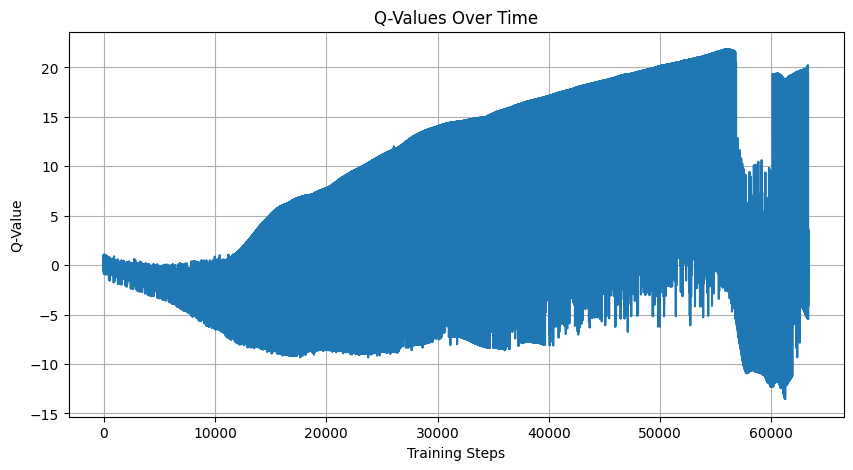

Episode 0 - Reward: -19.95, Epsilon: 1.000
Episode 100 - Reward: -19.25, Epsilon: 0.944
Episode 200 - Reward: -17.30, Epsilon: 0.889
Episode 300 - Reward: -29.25, Epsilon: 0.833
Episode 400 - Reward: 40.50, Epsilon: 0.778
Episode 500 - Reward: -20.25, Epsilon: 0.722
Episode 600 - Reward: -17.65, Epsilon: 0.667
Episode 700 - Reward: -21.05, Epsilon: 0.611
Episode 800 - Reward: -29.60, Epsilon: 0.556
Episode 900 - Reward: -21.60, Epsilon: 0.500
Episode 1000 - Reward: -14.65, Epsilon: 0.444
Episode 1100 - Reward: -19.60, Epsilon: 0.389
Episode 1200 - Reward: -18.00, Epsilon: 0.333
Episode 1300 - Reward: -17.20, Epsilon: 0.278
Episode 1400 - Reward: -16.35, Epsilon: 0.222
Episode 1500 - Reward: -17.25, Epsilon: 0.167
Episode 1600 - Reward: -18.30, Epsilon: 0.111
Episode 1700 - Reward: -17.25, Epsilon: 0.056
Episode 1800 - Reward: -19.70, Epsilon: 0.010
Episode 1900 - Reward: -17.15, Epsilon: 0.010


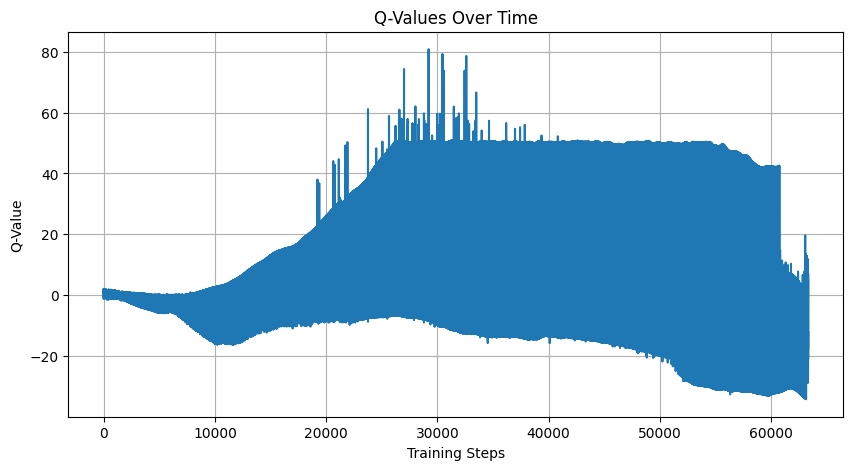

Episode 0 - Reward: -19.50, Epsilon: 1.000
Episode 100 - Reward: -15.50, Epsilon: 0.944
Episode 200 - Reward: -21.35, Epsilon: 0.889
Episode 300 - Reward: -15.15, Epsilon: 0.833
Episode 400 - Reward: -17.05, Epsilon: 0.778
Episode 500 - Reward: -20.20, Epsilon: 0.722
Episode 600 - Reward: -17.05, Epsilon: 0.667
Episode 700 - Reward: -19.40, Epsilon: 0.611
Episode 800 - Reward: -30.05, Epsilon: 0.556
Episode 900 - Reward: -20.65, Epsilon: 0.500
Episode 1000 - Reward: -18.15, Epsilon: 0.444
Episode 1100 - Reward: -24.70, Epsilon: 0.389
Episode 1200 - Reward: -13.05, Epsilon: 0.333
Episode 1300 - Reward: -18.30, Epsilon: 0.278
Episode 1400 - Reward: -17.50, Epsilon: 0.222
Episode 1500 - Reward: -16.65, Epsilon: 0.167
Episode 1600 - Reward: -25.10, Epsilon: 0.111
Episode 1700 - Reward: -15.05, Epsilon: 0.056
Episode 1800 - Reward: -17.50, Epsilon: 0.010
Episode 1900 - Reward: -17.50, Epsilon: 0.010


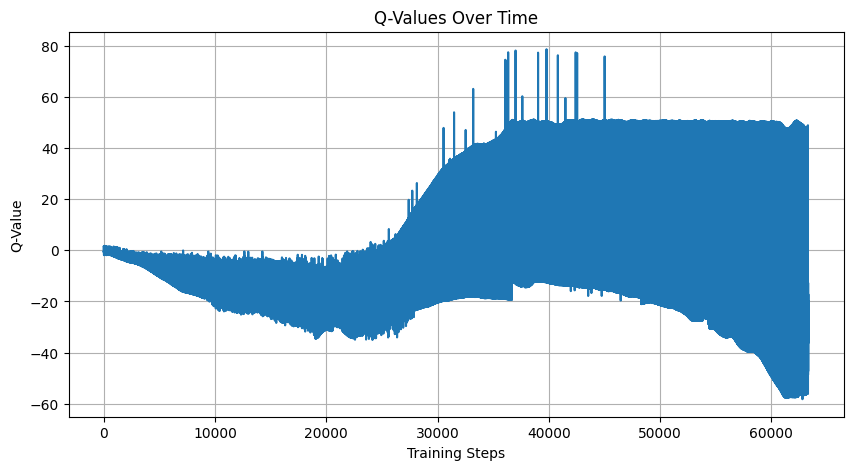

Episode 0 - Reward: -28.70, Epsilon: 1.000
Episode 100 - Reward: -21.20, Epsilon: 0.944
Episode 200 - Reward: -11.80, Epsilon: 0.889
Episode 300 - Reward: -21.25, Epsilon: 0.833
Episode 400 - Reward: -16.25, Epsilon: 0.778
Episode 500 - Reward: -23.25, Epsilon: 0.722
Episode 600 - Reward: -19.85, Epsilon: 0.667
Episode 700 - Reward: -20.90, Epsilon: 0.611
Episode 800 - Reward: -19.80, Epsilon: 0.556
Episode 900 - Reward: -29.90, Epsilon: 0.500
Episode 1000 - Reward: -18.55, Epsilon: 0.444
Episode 1100 - Reward: -16.95, Epsilon: 0.389
Episode 1200 - Reward: -30.65, Epsilon: 0.333
Episode 1300 - Reward: -21.10, Epsilon: 0.278


KeyboardInterrupt: 

In [12]:
results = []
for i, combo in enumerate(generate_param_combinations(hyperparams)):
    merged_params = {**shared_params, **combo}
    results.append(run_single_experiment(merged_params, run_id=i))
    

 ## Evaluation

In [ ]:
for i, result in enumerate(results):
    plt.plot(result["rewards"], label=f'Run {i}')
    plt.title("Training Rewards by Run")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.hist(reward_log, bins=10, edgecolor='black')
# plt.title("Reward Distribution")
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()
